In [36]:
# 1. membuat fungsi mfcc
import numpy as np
import copy
from scipy.io import wavfile
from matplotlib import pyplot as plt

def Hamming_Window(n):
    w = []
    for i in range(0,n):
        temp = 0.54 - 0.46 * np.cos((2*np.pi*i)/(n-1))
        w.append(temp)
    return w

def getMFCC(fileDirectory):
    #get sample rate,signal,pre emphasis, dan emphasized
    sample_rateku, signalku = wavfile.read(fileDirectory)
    timesku = np.arange(len(signalku))/float(sample_rateku)

    pre_emphasisku = 0.97
    emphasized_signalku = np.append(signalku[0], signalku[1:]- pre_emphasisku * signalku[:-1])
    
    # Ukuran frame adalah 25 milidetik,
    # dan overlap 15 milidetik (dalam ukuran waktu/detik)
    frame_sizeku = 0.025
    frame_strideku = 0.01

    # Konversi dari detik ke sample
    frame_lengthku = int(round(frame_sizeku * sample_rateku))
    frame_stepku = int(round(frame_strideku * sample_rateku))

    # Ukuran sinyal dalam Sample
    signal_lengthku = len(emphasized_signalku)

    # Pastikan setidaknya ada 1 frame
    num_framesku = int(np.ceil(float(np.abs(signal_lengthku - frame_lengthku)) / frame_stepku))

    pad_signal_lengthku = num_framesku * frame_stepku + frame_lengthku
    zku = np.zeros((pad_signal_lengthku - signal_lengthku))
    pad_signalku = np.append(emphasized_signalku, zku)

    indicesku = np.tile(np.arange(0, frame_lengthku), (num_framesku, 1))
    + np.tile(np.arange(0, num_framesku * frame_stepku, frame_stepku)
    , (frame_lengthku, 1)).T
    framesku = pad_signalku[indicesku.astype(np.int32, copy=False)]

    # windowing
    framesHWku = copy.copy(framesku)
    framesHWku *= np.hamming(frame_lengthku)

    # Magnitude of the FFT
    NFFTku = 512
    mag_framesku = np.absolute(np.fft.rfft(framesku, NFFTku))

    # Power Spectrum
    pow_framesku = ((1.0 / NFFTku) * ((mag_framesku) ** 2))

    # Misalkan yang diambil adalah:
    nfiltku = 40

    low_freq_melku = 0
    high_freq_melku = (2595 * np.log10(1 + (sample_rateku / 2) / 700)) # Convert Hz to Mel
    mel_pointsku = np.linspace(low_freq_melku, high_freq_melku, nfiltku + 2)
    hz_pointsku = (700 * (10**(mel_pointsku / 2595) - 1)) # Convert Mel to Hz
    bin = np.floor((NFFTku + 1) * hz_pointsku / sample_rateku)


    fbankku = np.zeros((nfiltku, int(np.floor(NFFTku / 2 + 1))))
    for m in range(1, nfiltku + 1):
        f_m_minus = int(bin[m - 1]) # left
        f_m = int(bin[m]) # center
        f_m_plus = int(bin[m + 1]) # right
        for k in range(f_m_minus, f_m):
            fbankku[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbankku[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banksku = np.dot(pow_framesku, fbankku.T)
    filter_banksku = np.where(filter_banksku == 0, np.finfo(float).eps, filter_banksku)
    filter_banksku = 20 * np.log10(filter_banksku) # dB

    num_cepsku = 13

    from scipy.fftpack import dct
    # Keep 2-14
    mfccku = dct(filter_banksku, type=2, axis=1, norm='ortho')[:, 1 : (num_cepsku + 1)]
    mfccku -= (np.mean(mfccku, axis=0) + 1e-8)
    
    plt.figure(figsize=(30, 4))
    plt.fill_between(timesku, emphasized_signalku)
    plt.xlim(timesku[0],timesku[-1])
    plt.xlabel('time(s)')
    plt.ylabel('amplitude')
    
    return plt, mfccku

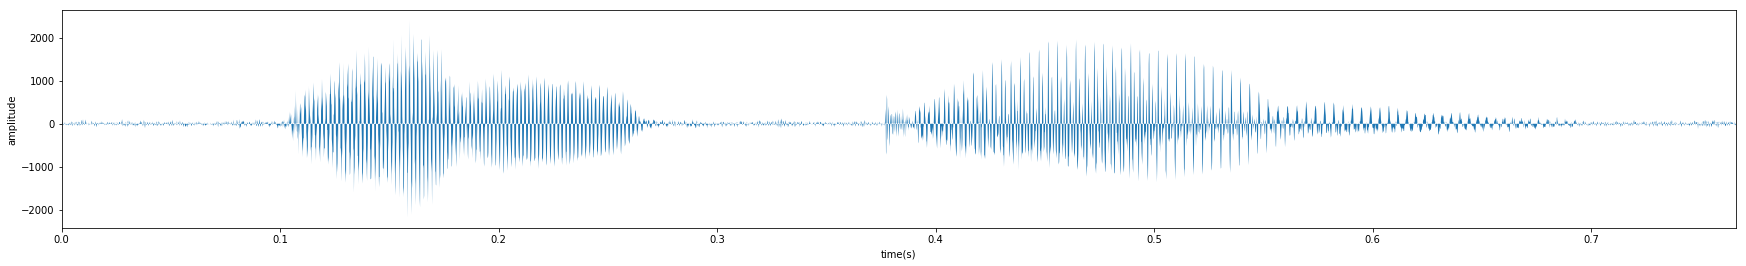

13


In [37]:
plot,mfcc = getMFCC('./Dataset/Rya/rya_1.wav')
plot.show()
print(len(mfcc[0]))